# Consumption prediction using SVR

In this notebook we will try to demonstrate the usage of SVR for consumption prediction for following day.First of all, let's load some consumption data.

In [1]:
import os
from datetime import datetime
from datetime import timedelta

from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import data as dutils
import prediction.predictor as prd
%matplotlib inline

In [2]:
# this is the first evaluation day
eval_day = datetime(2015,1,1)
# features used for traning
features = ['hour', 'weekday']
evals = 365
data_path = '.exports/user_data_joined'
users = os.listdir(data_path)

## Simple day-ahead prediction

Naše featury zatiaľ budú hodina a weekday a zoberieme dva týždne. Závislá premenná je samozrejme spotreba.

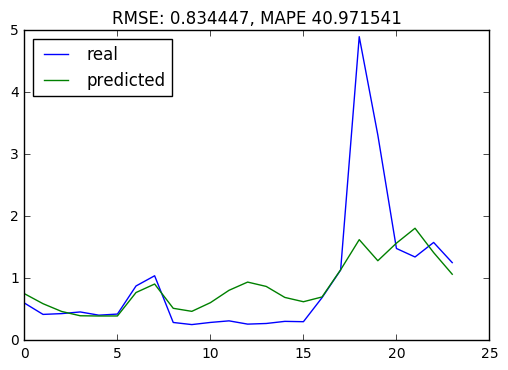

In [3]:
df = pd.read_csv('.exports/user_data_joined/user26.csv')

training_subset = dutils.select_range(df, datetime(2014, 1, 1), datetime(2014, 1, 14))

X = training_subset[['hour', 'weekday']].as_matrix()
y = training_subset['spotreba'].as_matrix()

clf = svm.SVR()
clf.fit(X, y)

testing_subset = dutils.select_range(df, datetime(2014, 1, 15), datetime(2014, 1, 15))

X_test = testing_subset[['hour', 'weekday']].as_matrix()
y_test = testing_subset['spotreba'].as_matrix()

y_pred = clf.predict(X_test)

fig, ax = plt.subplots(1,1)
ax.plot(y_test, label='real')
ax.plot(y_pred, label='predicted')
rmse_error = np.sqrt(mean_squared_error(y_test, y_pred))
mape_error = dutils.mape(y_pred, y_test)
ax.legend(loc=0)
ax.set_title('RMSE: %f, MAPE %f' % (rmse_error, mape_error))

For more robust evaluation, we will also compute the average errors of each day of whole year, using various lenghts for sliding window.

In [8]:
for i in range(1,9):
    days_to_train = 7*i
    mape_error, mse_error = prd.eval_on_multiple_days(df, eval_day, features, days_to_train, evals)
    print('Weeks to train %d, MAPE: %f, MSE: %f' % (i, mape_error, mse_error))

Weeks to train 1, MAPE: 57.076799, MSE: 0.887539
Weeks to train 2, MAPE: 53.126838, MSE: 0.857776
Weeks to train 3, MAPE: 53.601506, MSE: 0.860846
Weeks to train 4, MAPE: 53.349455, MSE: 0.864234
Weeks to train 5, MAPE: 54.078005, MSE: 0.874357
Weeks to train 6, MAPE: 54.635190, MSE: 0.889167
Weeks to train 7, MAPE: 55.415359, MSE: 0.901998
Weeks to train 8, MAPE: 56.196827, MSE: 0.918127


Same thing for another user, but lesser lenghts for sliding window is considered.

In [11]:
df = pd.read_csv('.exports/user_data_joined/user93.csv')

for i in range(1,3):
    days_to_train = 7*i
    mape_error, mse_error = prd.eval_on_multiple_days(df, eval_day, features, days_to_train, evals)
    print('Weeks to train %d, MAPE: %f, MSE: %f' % (i, mape_error, mse_error))

Weeks to train 1, MAPE: inf, MSE: 0.617511
Weeks to train 2, MAPE: inf, MSE: 0.603702


Two weeks seems to be the best lenght for sliding window. We can aslo see, that results differ between two users significantly. We will now compute the average MAPE and MSE of all users.

In [30]:


mape_errors = []
mse_errors = []

features = ['hour', 'weekday', 'month']

for index, user in enumerate(users[0:10]):
    print('Processing user %d/%d' % (index, len(users)))
    path = os.path.join(data_path, user)
    user_df = pd.read_csv(path)
    
    mape_error, mse_error = prd.eval_on_multiple_days(user_df, eval_day, features, 7*2, evals)
    
    mape_errors.append(mape_error)
    mse_errors.append(mse_error)
    print('RMSE: %f, aRMSE: %f' % (mse_error, np.mean(mse_errors)))
    
print('Average MAPE: %f, average MSE: %f' % (np.mean(mape_errors), np.mean(mse_errors)))

Processing user 0/129
RMSE: 0.371449, aRMSE: 0.371449
Processing user 1/129
RMSE: 0.836141, aRMSE: 0.603795
Processing user 2/129
RMSE: 0.726774, aRMSE: 0.644788
Processing user 3/129
RMSE: 0.440644, aRMSE: 0.593752
Processing user 4/129
RMSE: 0.714394, aRMSE: 0.617880
Processing user 5/129
RMSE: 0.896892, aRMSE: 0.664382
Processing user 6/129
RMSE: 0.877836, aRMSE: 0.694876
Processing user 7/129
RMSE: 1.129984, aRMSE: 0.749264
Processing user 8/129
RMSE: 0.504826, aRMSE: 0.722104
Processing user 9/129
RMSE: 0.936874, aRMSE: 0.743581
Average MAPE: nan, average MSE: 0.743581


## Add derivates as a features

In [7]:
mape_errors = []
mse_errors = []

features = ['hour', 'weekday', 'month', 'derivative']

for index, user in enumerate(users[0:10]):
    print('Processing user %d/%d' % (index, len(users)))
    path = os.path.join(data_path, user)
    user_df = pd.read_csv(path)
    
    der = [0, 0, *np.diff(user_df['spotreba'])[:-1]]
    user_df['derivative'] = der
    
    mape_error, mse_error = prd.eval_on_multiple_days(user_df, eval_day, 'spotreba', features, 7*2, evals)
    
    mape_errors.append(mape_error)
    mse_errors.append(mse_error)
    print('RMSE: %f, aRMSE: %f' % (mse_error, np.mean(mse_errors)))

Processing user 0/129
RMSE: 0.363705, aRMSE: 0.363705
Processing user 1/129
RMSE: 0.789860, aRMSE: 0.576783
Processing user 2/129
RMSE: 0.676073, aRMSE: 0.609879
Processing user 3/129
RMSE: 0.414643, aRMSE: 0.561070
Processing user 4/129
RMSE: 0.645411, aRMSE: 0.577938
Processing user 5/129
RMSE: 0.813323, aRMSE: 0.617169
Processing user 6/129
RMSE: 0.803766, aRMSE: 0.643826
Processing user 7/129
RMSE: 1.088028, aRMSE: 0.699351
Processing user 8/129
RMSE: 0.475033, aRMSE: 0.674427
Processing user 9/129
RMSE: 0.879460, aRMSE: 0.694930


## Prediction for whole year

Back to our first user. Now we will try to train on whole year and include a month as a feature. Then we will predict the whole year.

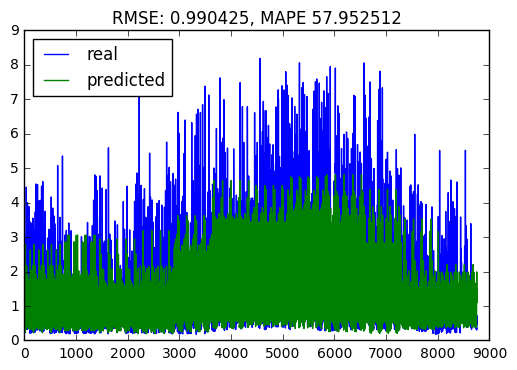

In [23]:
def predict_year(df, features, target):
    training_subset = dutils.select_range(df, datetime(2014, 1, 1), datetime(2014, 12, 31))

    X = training_subset[features].as_matrix()
    y = training_subset[target].as_matrix()

    testing_subset = dutils.select_range(df, datetime(2015, 1, 1), datetime(2015, 12, 31))

    X_test = testing_subset[features].as_matrix()
    y_test = testing_subset[target].as_matrix()

    clf = svm.SVR()
    clf.fit(X, y)

    y_pred = clf.predict(X_test)

    fig, ax = plt.subplots(1,1)
    ax.plot(y_test, label='real')
    ax.plot(y_pred, label='predicted')
    rmse_error = np.sqrt(mean_squared_error(y_test, y_pred))
    mape_error = dutils.mape(y_pred, y_test)
    ax.legend(loc=0)
    ax.set_title('RMSE: %f, MAPE %f' % (rmse_error, mape_error))

df = pd.read_csv('.exports/user_data_joined/user26.csv')

features = ['hour', 'weekday', 'month']
target   = 'spotreba'

predict_year(df, features, target)

Again, lets try another user

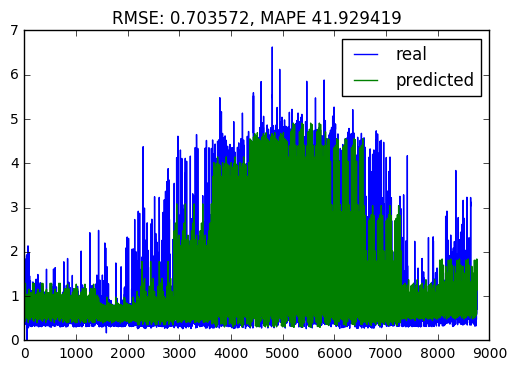

In [24]:
df = pd.read_csv('.exports/user_data_joined/user93.csv')

predict_year(df, features, target)

## Prediction for aggregated consumption

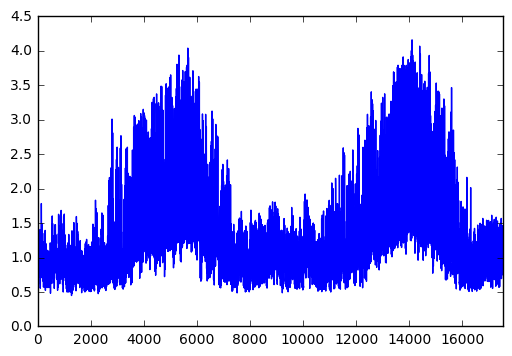

In [3]:
columns = ['year', 'month', 'day', 'hour', 'consumption']
df_avg = pd.read_csv('.exports/aggregations/average_all_users.csv', names=columns)
df_avg['consumption'].plot()

df_avg['weekday'] = [datetime(int(x['year']), int(x['month']), int(x['day'])).weekday() for index, x in df_avg.iterrows()]

In [6]:
eval_day = datetime(2015,1,1)
# features used for traning
features = ['hour', 'weekday', 'month']
evals = 365

prd.eval_on_multiple_days(df_avg, eval_day, 'consumption', ['hour', 'month','weekday'], 7*2, evals)

(14.932274926725945, 0.23373061561673814)

In [7]:
weather_df = pd.read_csv('.exports/weather_data_joined.csv')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 5: invalid start byte